# Chapter 4 of book: Mnist Basics - Under the hood: Training a Digit Classifier
https://nbviewer.org/github/fastai/fastbook/blob/master/04_mnist_basics.ipynb

We will start by using computer vision to introduce fundamental tools and concepts for deep learning
- discuss the roles of arrays and tensors and of broadcasting, a powerful way to use them expressively
- stochastic gradient descent (SGD), mechanism for learning by updating weights automatically
- choice of a loss function for our basic classification task
- role of mini-batches
- describe the math that a basic neural network is actually doing

This chapter is a foundational chapter, all concepts depend on each other

First steps is to consider how images are represented in a computer

# Pixels: The Foundations of Computer Vision
In order to understand what happens in a computer vision model, we need to understand how computers handle images
We will use the MNIST dataset https://en.wikipedia.org/wiki/MNIST_database
A dataset of images of handwritten digits

In [ ]:
# install pytorch - https://pytorch.org/get-started/locally/
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())

current_device = torch.cuda.current_device()
print(torch.cuda.device(current_device))
print(torch.cuda.get_device_name(current_device))

In [1]:
# for initial tutorial, we try to create a model for classifying any image as a 3 or 7
from fastai.vision.all import *

path = untar_data(URLs.MNIST_SAMPLE)
print(path)

# see what is in this directory
# a method in fastai class called "L", like a list
# the .ls() method will print the count of items also
print(path.ls())

C:\Users\jerem\.fastai\data\mnist_sample
[Path('C:/Users/jerem/.fastai/data/mnist_sample/labels.csv'), Path('C:/Users/jerem/.fastai/data/mnist_sample/train'), Path('C:/Users/jerem/.fastai/data/mnist_sample/valid')]


In [4]:
# There are train and valid dataset in separate folders
(path/"train").ls()

# we say that "3" and "7" are the labels (or targets) in this dataset

(#2) [Path('C:/Users/jerem/.fastai/data/mnist_sample/train/3'),Path('C:/Users/jerem/.fastai/data/mnist_sample/train/7')]

In [3]:
# we will do a sorted on the files so that the order is the same
threes = (path/"train"/"3").ls().sorted()
sevens = (path/"train"/"7").ls().sorted()

threes

(#6131) [Path('C:/Users/jerem/.fastai/data/mnist_sample/train/3/10.png'),Path('C:/Users/jerem/.fastai/data/mnist_sample/train/3/10000.png'),Path('C:/Users/jerem/.fastai/data/mnist_sample/train/3/10011.png'),Path('C:/Users/jerem/.fastai/data/mnist_sample/train/3/10031.png'),Path('C:/Users/jerem/.fastai/data/mnist_sample/train/3/10034.png'),Path('C:/Users/jerem/.fastai/data/mnist_sample/train/3/10042.png'),Path('C:/Users/jerem/.fastai/data/mnist_sample/train/3/10052.png'),Path('C:/Users/jerem/.fastai/data/mnist_sample/train/3/1007.png'),Path('C:/Users/jerem/.fastai/data/mnist_sample/train/3/10074.png'),Path('C:/Users/jerem/.fastai/data/mnist_sample/train/3/10091.png')...]

In [11]:
# taking a look at one of the three image
from PIL import Image
# help(Image)

im3_path = threes[1]
im3 = Image.open(im3_path)
im3

We are using the `Image` class from Python Imaging Library (PIL), the most widely used Python package for opening, manipulating, and viewing images

In a computer, everything is represented as a number
To view the numbers that make up this image, we have to convert it to a NumPy array or a PyTorch tensor

In [14]:
# e.g. a section of the image, converted to NumPy array
# help(array)
# 4:10 means we request the rows from index 4 (included) to index 10 (not included).
# same for the columns
# NumPy indexes from top to bottom and left to right
# so we are seeing the top left corner of the image
array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [15]:
# same thing, as a PyTorch tensor instead
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [27]:
# slice the array to pick just the part we want to see, then use Pandas DataFrame to color code the values using gradient
# to show how the image is created from the pixel values

# https://pandas.pydata.org/docs/reference/api/pandas.io.formats.style.Styler.background_gradient.html
# https://matplotlib.org/stable/users/explain/colors/colormaps.html

import pandas as pd

img3_t = tensor(im3)
df = pd.DataFrame(img3_t[4:15, 4:22])
df.style.set_properties(**{"font-size": "8pt"}).background_gradient("Greys")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


The background white pixels are stored as number 0, black is the number 255
Shades of grey are between 0 and 255
The entire image contains 28 pixels across and 28 pixels down, for a total of 784 pixels

How would we program the computer to recognize these 2 different digits?

# First Try: Pixel Similarity
First idea: find the average pixel value of every pixel of the "3"s then do the same for the "7"s
We will have 2 group averages, defining what we might call the "ideal" 3 and 7
Then to classify an image, we will see which of the two digits they are more similar to

This will make a good baseline
- Baseline: simple model which you are confident should perform reasonably well
- Should be easy to implement, easy to test, so that you can test each of your improved ideas
- Without starting with a baseline, it is difficult to know whether your fancy models are doing any good
- Another good approach is to search around and find other people that have solved similar problems as yours, and download and run their code on your dataset

In [4]:
# Create a tensor containing all of our 3s stacked together
# Use python list comprehension to create a plain list of the single image tensors
seven_tensors = [tensor(Image.open(im7)) for im7 in sevens]
three_tensors = [tensor(Image.open(im3)) for im3 in threes]

len(three_tensors), len(seven_tensors)

(6131, 6265)

A list comprehension looks like this: `new_list: [f(o) for o in a_list if o > 10]`
- return every element of `a_list` that is greater than 10, after passing it through function `f`
- Three parts
    1) Collection you are iterating over (`a_list`)
    2) Optional filter (`if o > 10`)
    3) Something to do to each element (`f(o)`)

<Axes: >

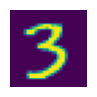

In [7]:
# check that one image looks okay
# need fastai show_image to display the tensor image, or else jupyter will print the tensor as values
show_image(three_tensors[1])

For every pixel position, we want to compute the average over all the images of the intensity of that pixel
We will first combine all the images in this list into a single three-dimensional tensor
- Described as rank-3 tensor

We often need to stack up individual tensors in a collection into a single tensor
PyTorch has a function `stack` that we can use for this purpose

Some operations in PyTorch, such as taking a mean, require us to cast our integer types to float types
Since we will need this later, we will cast our stacked tensor to float now

Generally when images are floats, the pixel values are expected to be between 0 and 1, so we will divide by 255 here

In [5]:
stacked_threes = torch.stack(three_tensors).float() / 255
stacked_sevens = torch.stack(seven_tensors).float() / 255

stacked_threes.shape

torch.Size([6131, 28, 28])

The most important attribute of a tensor is its `shape`
**shape** Tells the length of each axis
torch.Size([6131, 28, 28])
- 6131 images, each of size 28 x 28 pixels
- Nothing specifically about this tensor that says the first axis is the number of images, second is the height and third is width
- The semantics is entirely up to us and how we construct it
- For PyTorch, it is just a bunch of numbers in memory

**Length of a tensor's shape is its rank**
rank = len(stacked_threes.shape)
=> 3

In [8]:
len(stacked_threes.shape)

# RANK is the number of axes or dimensions in a tensor
# SHAPE is the size of each axis of a tensor

3

In [9]:
# Get tensor rank directly using ndim
stacked_threes.ndim # 3

3

torch.Size([28, 28])


<Axes: >

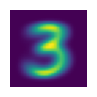

In [7]:
# we can calculate what the ideal 3 looks like
# calculate the mean of all the image tensors by taking mean along dimension 0 our stacked, rank 3 tensor
# this is the dimension that indexes over all the images

# For each pixel position, this will compute the average of that pixel over all images
# the result will be one value for each pixel position, or a single image

# mean over the first dimension
# tensor shape -> torch.Size([6131, 28, 28])
mean_three = torch.mean(stacked_threes, 0) # or stacked_threes.mean(0)

print(mean_three.shape) # will be torch.Size([28, 28])
show_image(mean_three) # show the ideal number 3

torch.Size([28, 28])


<Axes: >

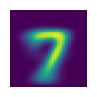

In [8]:
# get the mean of sevens!
mean_seven = torch.mean(stacked_sevens, 0)

print(mean_seven.shape)
show_image(mean_seven)

Let's now pick an arbitrary 3 and measure its distance from our "ideal digits."

**stop: Stop and Think!:** How would you calculate how similar a particular image is to each of our ideal digits? 
Remember to step away from this book and jot down some ideas before you move on! 
Research shows that recall and understanding improves dramatically when you are engaged with the learning process by solving problems, experimenting, and trying new ideas yourself

- Possible ideas
Take an image, take each pixel and calculate the mean squared error from the "ideal" three and "ideal" seven.
The one that is closer will be chosen as the possible image

How to determine the distance from our ideal 3?
We can't just add up the differences between the pixels of this image and the ideal digit
Some differences will be positive while others will be negative and these differences will cancel out, resulting in an image that is too dark in some areas and some that are too light in some areas to be shown as zero differences, which is misleading!

There are two main ways data scientists measure distance in this context
1) Take the mean of the absolute differences (absolute value is a function that replaces negative values with positive values). This is called **mean aboslute difference** or **L1 norm**
2) Take the mean of the square of differences (which makes everything positive) and then take the square root (does the unsquaring). This is **root mean squared error (RMSE) or L2 norm**

torch.Size([28, 28])
tensor(0.1114) tensor(0.2021)


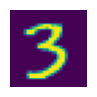

In [9]:
a_3 = stacked_threes[1]
print(a_3.shape)
show_image(a_3)

# L1 norm - take mean of the absolute value of differences
dist_3_abs = (a_3 - mean_three).abs().mean()
# L2 norm - take square root of (mean of square of differences) => root mean squared error (RMSE)
dist_3_sqr = ((a_3 - mean_three)**2).mean().sqrt()

print(dist_3_abs, dist_3_sqr)

In [11]:
# L1 norm - take absolute differences and get the mean
dist_7_abs = (a_3 - mean_seven).abs().mean()
# L2 norm - Root mean squared error RMSE - take squared differences, get mean, then do square root
dist_7_sqr = ((a_3 - mean_seven)**2).mean().sqrt()

print(dist_7_abs, dist_7_sqr)

tensor(0.1586) tensor(0.3021)


For both cases, the distance between our "3" and the "ideal" 3 is less than the distance to the ideal 7
So our simple model is right in this case

PyTorch already provides both of these as **loss functions**
These are inside `torch.nn.functional` which the PyTorch recommends importing as `F` (and is available by default under the name in fastai)

In [36]:
import torch.nn.functional as F

# help(F)

help(F.l1_loss)
help(F.mse_loss)

# L1 norm, take mean of absolute differences
print("L1 norm")
print(F.l1_loss(input=a_3.float(), target=mean_three), F.l1_loss(input=a_3, target=mean_seven))

# L2 norm, take sqrt of mean of squared differences, need to sqrt after calling F.mse_loss
# https://discuss.pytorch.org/t/rmse-loss-function/16540
print("\nL2 norm, AKA Root mean squared error")
print(F.mse_loss(input=a_3.float(), target=mean_three).sqrt(), F.mse_loss(input=a_3, target=mean_seven).sqrt())

# mse means mean squared error, l1 refers to the standard mathematical jargon for mean absolute value (in math its called L1 norm)

Help on function l1_loss in module torch.nn.functional:

l1_loss(input: torch.Tensor, target: torch.Tensor, size_average: Optional[bool] = None, reduce: Optional[bool] = None, reduction: str = 'mean') -> torch.Tensor
    l1_loss(input, target, size_average=None, reduce=None, reduction='mean') -> Tensor
    
    Function that takes the mean element-wise absolute value difference.
    
    See :class:`~torch.nn.L1Loss` for details.

Help on function mse_loss in module torch.nn.functional:

mse_loss(input: torch.Tensor, target: torch.Tensor, size_average: Optional[bool] = None, reduce: Optional[bool] = None, reduction: str = 'mean') -> torch.Tensor
    mse_loss(input, target, size_average=None, reduce=None, reduction='mean') -> Tensor
    
    Measures the element-wise mean squared error.
    
    See :class:`~torch.nn.MSELoss` for details.

L1 norm
tensor(0.1114) tensor(0.1586)

L2 norm, AKA Root mean squared error
tensor(0.2021) tensor(0.3021)


# Difference between L1 norm and mean squared error (MSE) is that MSE will penalize bigger mistakes more heavily than L1 norm (and be more lenient with small mistakes)

We completed various mathematical operations on PyTorch tensors. If you have done some numeric programming in NumPy before, you may recognize these as being similar to NumPy arrays

# NumPy Arrays and PyTorch Tensors
NumPy is the most widely used library for scientific and numeric programming in Python
Provides similar functionality and API as PyTorch BUT it does not support using the GPU or calculating gradients, which are both critical for deep learning

We will therefore generally use PyTorch tensors instead of NumPy arrays, whenever possible

(Note that fastai adds some features to NumPy and PyTorch to make them a bit more similar to each other. If any code in this book doesn't work on your computer, it's possible that you forgot to include a line like this at the start of your notebook: `from fastai.vision.all import *`.)

But what are arrays and tensors, and why should you care?

Python is slow compared to many languages. Anything fast in Python, NumPy, or PyTorch is likely to be a wrapper for a compiled object written (and optimized) in another language—specifically C.
**NumPy arrays and PyTorch tensors can finish computations many thousands of times faster than using pure Python.**

A NumPy array is a multidimensional table of data, with all items of the same type. This can be any type, they can even be arrays of arrays, with the innermost arrays being different sizes (jagged array)
By multidimensional table, we mean, e.g. list (dimension of one), table or matrix (dimension of two), table of tables or cube (dimension of three), and so forth
If the items are all of some simple type such as integer or float, then NumPy will store them as a compact C data structure in memory (where NumPy shines)
NumPy has a wide variety of operators and methods that can run computations on these compact structures at the same speed as optimized C, because they are written in optimized C.

A PyTorch tensor is nearly the same thing as a NumPy array, but with an additional restriction that unlocks some additional capabilities. It's the same in that it, too, is a multidimensional table of data, with all items of the same type. However, the restriction is that a tensor cannot use just any old type—it has to use a single basic numeric type for all components. For example, a PyTorch tensor cannot be jagged. It is always a regularly shaped multidimensional rectangular structure.

The vast majority of methods and operators supported by NumPy on these structures are also supported by PyTorch, but PyTorch tensors have additional capabilities. One major capability is that these structures can live on the GPU, in which case their computation will be optimized for the GPU and can run much faster (given lots of values to work on). In addition, PyTorch can automatically calculate derivatives of these operations, including combinations of operations. As you'll see, it would be impossible to do deep learning in practice without this capability.

    S: If you don't know what C is, don't worry as you won't need it at all. In a nutshell, it's a low-level (low-level means more similar to the language that computers use internally) language that is very fast compared to Python. To take advantage of its speed while programming in Python, try to avoid as much as possible writing loops, and replace them by commands that work directly on arrays or tensors.

Perhaps the most important new coding skill for a Python programmer to learn is how to effectively use the array/tensor APIs. We will be showing lots more tricks later in this book, but here's a summary of the key things you need to know for now.

In [42]:
"""
Create an array or tensor => pass a list (or list of lists, or list of lists of lists, etc) 
to `array()` (NumPy) or `tensor()` (PyTorch)
"""
data = [[1,2,3],[4,5,6]]
arr = array(data) # NumPy
tns = tensor(data) # PyTorch

# All the operations that follow are shown on tensors, but the syntax and results for NumPy arrays is identical.

# Select a row (note that, like lists in Python, tensors are 0-indexed, index 1 refers to second row/column)
print(tns[1]) # tensor([4,5,6])

tensor([4, 5, 6])


In [48]:
# or a column, by using `:` to indicate all of the first axis (we sometimes refer to dimension of tensors/arrays as axes
print(tns[:, 1]) # tensor([2, 5])

# e.g. drop first row of each entry
print(tns[1:])

# can give python slice syntax (e.g. [start : end])
print(tns[1, 1:3]) # get second entry, slice from 2 element 2 item => tensor([5, 6])

# And you can use the standard operators such as +, -, *, /:
print(tns + 1) # tensor([[2,3,4],[5,6,7]])

# tensors have a type
print(tns.type()) # torch.LongTensor

# will auto change type as needed, e.g. from int to float
print(tns * 1.5)
print((tns * 1.5).type())

tensor([2, 5])
tensor([[4, 5, 6]])
tensor([5, 6])
tensor([[2, 3, 4],
        [5, 6, 7]])
torch.LongTensor
tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])
torch.FloatTensor


So, is our baseline model any good? To quantify this, we must define a metric.

# Computing Metrics Using Broadcasting
A metric is a number that is calculated based on the predictions of our model, and the correct labels in our dataset, to tell us how good our model is
e.g. We could use either of the functions in the previous section, mean squared error (L2 norm) or L1 norm (mean absolute error), and take the average of them over the whole dataset
However, neither of these numbers are very understandable to most people
In practice, we normally use **accuracy** as the metric for classification models

We want to calculate our metrics over a **validation set**
This is so that we don't inadvertently overfit (train a model to work well only for our training data)
Not really a risk with pixel similarity model we are using here as a first try, since there is no trained components, but we will use a validation set anyway in order to follow best practices

To get a validation set, we need to remove some of the data from the training data entirely, so it is not seen by the model at all
As it turns out, the creators of the MNIST dataset have already done this for us. Do you remember how there was a whole separate directory called valid? That's what this directory is for!

To start, we will create tensors for our 3s and 7s from that "valid" directory
These are the tensors we will use to calculate a metric measuring the quality of our first try model, which measures distance from an ideal image

[Path('C:/Users/jerem/.fastai/data/mnist_sample/valid/3'), Path('C:/Users/jerem/.fastai/data/mnist_sample/valid/7')]
3 tensor shape = torch.Size([1010, 28, 28])
3 tensor rank = 3
7 tensor shape = torch.Size([1028, 28, 28])
7 tensor rank = 3


<Axes: >

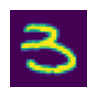

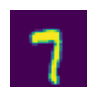

In [15]:
# help(torch.stack)
print((path/"valid").ls())
valid_3_path = path/"valid"/"3"
valid_7_path = path/"valid"/"7"

# help(Image.open) # PIL.Image
# print(valid_3_path.ls().sorted())

valid_3_tensors = torch.stack([tensor(Image.open(t)).float()/255 for t in valid_3_path.ls().sorted()])
print(f"3 tensor shape = {valid_3_tensors.shape}")
print(f"3 tensor rank = {valid_3_tensors.ndim}")
# print(valid_3_tensors[1])
show_image(valid_3_tensors[1])

valid_7_tensors = torch.stack([tensor(Image.open(t)).float()/255 for t in valid_7_path.ls().sorted()])
print(f"7 tensor shape = {valid_7_tensors.shape}")
print(f"7 tensor rank = {valid_7_tensors.ndim}")
show_image(valid_7_tensors[1])

# tensor shape is the length of each axes
# tensor rank is the length of shape (how many axes are there)

Good to get into habit of checking shapes of tensors as you go
We have two tensors, one representing 3s validation set of 1010 images of size 28x28
one representing 7s validation set of 1028 images of size 28x28

We ultimately want to write a function `is_3` that decide if an arbitrary image is a 3 or a 7
It will do this by deciding which of our two "ideal" digits the arbitrary image is closer to
We need to define a notion of distance - a function that calculate the distance between two images

In [17]:
# L1 norm, absolute error
# mean can accept a tuple, dim (int or tuple of ints) – the dimension or dimensions to reduce.

# https://forums.fast.ai/t/understanding-mean-1-2-in-mnist-distance/84430
"""
The axis parameter can be int or tuple of ints. Those ints represent axes along which the means are computed. The default is to compute the mean of the flattened array (1).

Negative ints are used to specify ‘count from last’. The axis -1 is equal to last axis (which in this case, axis 1) and -2 to one before last (which in this case, axis 0).
"""
def mnist_distance(a, b):
    return (a - b).abs().mean((-1, -2))

# a_3 is the arbitrary sample, mean_three is the "ideal" 3
# both are single image tensors with shape [28, 28] (shape is the length of each axes)
mnist_distance(a_3, mean_three)

tensor(0.1114)

In order to calculate a metric for overall accuracy, we need to calculate the distance to the ideal 3 for **every image in the validation set**

How do we do this calculation? We could write a for loop over all the single image tensors that are stacked in our validation set tensor (valid_3_tensors) which has shape of [1010, 28, 28] representing 1010 images

But there is a better way

Something interesting happens when we take the exact same distance function, designed for comparing two single images but we pass in the argument valid_3_tensors (the tensor that represents the 3s validation set)

In [19]:
# we are doing mean((-1, -2)), so for [1010, 28, 28], we are taking mean across last 2 axis
valid_3_dist = mnist_distance(valid_3_tensors, mean_three)
valid_3_dist, valid_3_dist.shape

(tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260]),
 torch.Size([1010]))

Instead of complaining about shapes not matching between "a" and "b", it returned the distance for every single image as a vector (rank 1 tensor) of length 1010 (the number of 3s in the validation set)

How?

```python
def mnist_distance(a, b):
    return (a - b).abs().mean((-1, -2))
```

In "mnist_distance", there is `(a - b)`, PyTorch when trying in the subtraction operation between two tensors of different ranks, will use broadcasting
Broadcasting is where it will automatically expand the tensor with the smaller rank (length of shape) (shape is the length of axes) to become the same size as the one with the larger rank
- Makes tensor code much easier to write

After broadcasting, the two tensors arguments will have the same rank, PyTorch will apply usual logic of two tensors of the same rank; performs the operation on each corresponding element of the two tensors, and return the tensor result

`tensor([1,2,3]) + tensor(1)` will return `tensor([2,3,4])`
- will expand the rank of `tensor(1)` to `tensor([1,1,1])` and then perform the addition

In our mnist_distance case, PyTorch will treat `mean_three` as a rank 2 tensor representing a single image, as if it were 1010 copies of the same image, and then subtracts each of these copies from each 3 in our validation set
What shape would you expect this tensor to have? 
Try to figure it out before looking at the answer below

`(valid_3_tensors - mean_three).shape` will return `tensor([1010, 28, 28])`
- mean_three will be broadcasted to have shape [1010, 28, 28], from [28, 28]
- We will be calculating the difference between our "ideal" 3 and each of the 1010 3s in the validation set, for each 28x28 images. This results in shape [1010, 28, 28]

There are a couple of important points about how broadcasting is implemented, which makes it valuable not just for expressivity but also for performance
- PyTorch doesn't actually copy `mean_three` 1010 times. It pretends it were a tensor of that shape, but doesn't allocate any additional memory
- It does the whole calculation in C (or if you are using GPU, in CUDA, the equivalent of C on the GPU), tens of thousands times faster than pure Python (up to millions of times faster on GPU)

This is true for all broadcasting and elementwise operations and functions done in PyTorch
Important for creating efficient PyTorch code

Next in `mnist_distance` function is `abs`, when applied to a tensor, it applies the method to each individual element in the tensor and returns a tensor of the results (applies the method "elementwise")
We get back 1010 matrices of absolute values

Finally, the function calls `mean((-1, -2))`, the tuple `(-1, -2)` represents a range of axes
In Python, `-1` refers to the last element, and `-2` refers to the second to last
This tells PyTorch we want to take the mean ranging over the values indexed by the last two axes of the tensor
The last two axes are the horizontal and vertical dimensions of an image
After taking the mean over the last two axes, we are left with just the first tensor axis, which indexes over our images, which is why the final size was 1010.
In other words, for each image, we averaged the intensity of all the pixels in that image

We can use `mnist_distance` to figure out whether an image is a 3 or not by using the following logic:
- If the distance between the digit in question and the ideal 3 is less than the distance to the ideal 7, then it is a 3
- This function will automatically do broadcasting and be applied elementwise, just like all PyTorch functions and operators

In [20]:
def is_3(x):
    return mnist_distance(x, mean_three) < mnist_distance(x, mean_seven)

# when converting the boolean response to float, we get 1.0 for True and 0.0 for False
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [21]:
# using broadcasting, we can test over the entire validation set
is_3(valid_3_tensors)

tensor([ True,  True,  True,  ..., False,  True,  True])

In [26]:
# calculate accuracy of each of the 3s and 7s, taking average of that function
# for checking 7s, need to take accuracy as 1 - (is_3)
accuracy_3s = is_3(valid_3_tensors).float().mean()
accuracy_7s = (1 - is_3(valid_7_tensors).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

This is an example of how to define a metric conveniently using broadcasting

To do better, we need a system that can automatically modify itself to improve its performance
Time to talk about the training process and Stochastic Gradient Descent (SGD)

# Stochastic Gradient Descent (SGD)

Do you remember the way that Arthur Samuel described machine learning, which we quoted in "chapter_intro"?

    : Suppose we arrange for some automatic means of testing the effectiveness of any current weight assignment in terms of actual performance and provide a mechanism for altering the weight assignment so as to maximize the performance. We need not go into the details of such a procedure to see that it could be made entirely automatic and to see that a machine so programmed would "learn" from its experience.

The pixel similarity approach does not allow for this. There is no weight assignment, or any way to improve based on testing the effectiveness of a weight assignment
We can't improve our pixel similarity approach by modifying a set of parameters

We have to first represent our task in the way that Arthur Samuel described it

Instead of finding similarity between an image and an "ideal image", we could instead look at each individual pixel and come up with a set of weights for each one, such that the highest weights are associated with those pixels most likely to be black for a particular category
e.g. pixels toward bottom right are not very likely to be activated for a 7, so they should have a low weight for a 7, and they should have a high weight for an 8

This can be represented as a function and set of weight values for each possible category - e.g. probability of being the number 8
```python
def pr_eight(x, w):
    # x is an image, represented as a vector
    # w is the weight, represented as a vector
    return (x * w).sum()
```
- Assuming that x is the image, represented as a vector - with all of the rows stacked up end to end into a single long line
- Weights are a vector w
- We need some way to update the weights to make it a bit better
- We can then repeat this step a number of times, making the weights better and better, until they are as good as we can make them

We want to find the specific values for the vector w so that the result of our function is high for those images that are actually 8s, and low for those images that are not
Searching for the best vector w is a way to search for the best function for recognising 8s (because we are not yet using a deep neural network, we are limited by what our function can actually do - we are going to fix that constraint later in this chapter)

Here are the steps we are going to require, to turn this function into a machine learning classifier
1) Initialize the weights
2) For each image, use these weights to predict whether it appears to be a 3 or 7
3) Based on these predictions, calculate how good the model is (its loss)
4) Calculate the gradient, which measure for each weight, how changing that weight would change the loss
5) Step (change) all the weights based on that calculation (in step 4)
6) Go back to step 2, and repeat the process
7) Iterate until you decide to step the training process (e.g. because the model is good enough or you don't want to wait any longer)

These steps are the key to training of all deep learning models

The general approach to each one generally follows some basic principles. Here are a few guidelines:
- **Initialize**: We init the parameters to random values. Since we know that we have a routine to improve these weight, just starting with random weights works well. e.g. we could also init them to the percentage of times that pixel is activated for that category
- **Loss**: This is what is refered by Samuel as "testing the effectiveness of any current weight assignment in terms of actual performance". We need some function that will return some number that is small if the performance of the model is good and large when the performance is worse. (standard approach is to treat small loss as good, large loss as bad (just a convention))
- **Step**: Simple way to figure out whether a weight should be increased a bit or decreased a bit, is to just try it. Increase / decrease by a small amount and see if the loss goes up or down. However this can be slow! The magic of calculus will allow us to figure out in which direction, and by roughly by how much, without having to try all these small changes (CALCULATE GRADIENTS)
- **Stop**: Once we have decided how many epochs to train the model, we apply that decision. For our digit classifier, we would keep training until the accuracy of the model started getting worse, or we ran out of time

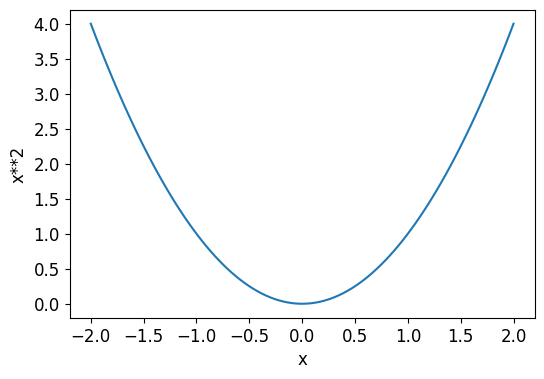

In [36]:
# E.g. with quadratic function
from fastbook import *

def f(x):
    return x**2
# where f(x) is the loss function, and x is a weight parameter of the function
plot_function(f, "x", "x**2")

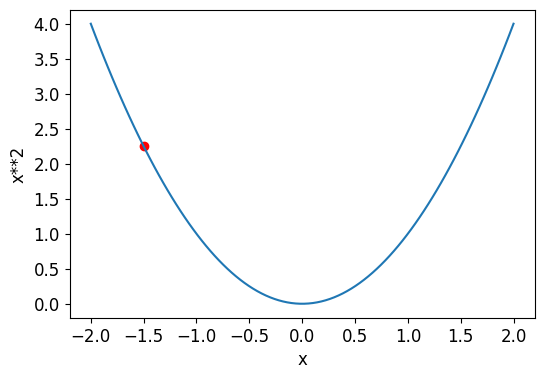

In [37]:
# The first step is to get a random initializer number for the weights, and calculate the loss value
plot_function(f, "x", "x**2")
plt.scatter(-1.5, f(-1.5), color="red")

# we can increase and decrease the adjustment, by some factor of the slope at a particular point
# we can change our weight a little in the direction of the slope, calculate the loss and adjustment again, 
# and repeat this a few times, we will approach the lowest point on our curve

# to make this process faster, there are some ways in the book that we will see later, 
# that can allow us to choose better steps